In [69]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Reds):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def time(expr):
    start = datetime.datetime.now()
    code = eval(expr)
    end = datetime.datetime.now()
    return (end-start, code)

sa_columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                           "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                           "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
                           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
                           "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                           "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
sf_columns = ["duration", "service", "src_bytes", "dst_bytes"]

In [68]:
# sf = datasets.fetch_kddcup99(subset='SF', random_state=0, percent10=False)
# dfsf = pd.DataFrame(sf.data, columns=sf_columns)
df = pd.read_csv('kddcup.data.csv', delimiter=',')
df.columns = sa_columns + ["target"]
dfsf = df[(df["flag"]=='SF') & (df["logged_in"] == 1)]
dfsf = dfsf[sf_columns+["target"]]
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]=='normal.'])/len(dfsf)
print(f"SF anomaly rate is {anomaly_rate_sf:.1%}")

dfsf['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = leSF.fit_transform(dfsf[f])

X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.33, random_state=0)

SF anomaly rate is 0.5%


In [49]:
num_extimators = 100
max_samples = 0.25
contamination = 0.2
eps = 0.2

ifsf = IsolationForest(max_samples=max_samples, random_state=0, contamination=contamination, n_estimators=num_extimators, n_jobs=-1)
lofsf = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=contamination, n_jobs=-1)
ocsvm = OneClassSVM(nu=contamination, kernel="rbf",gamma=0.1)
dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1)
estimators = {
    "if": ifsf,
    "lof": lofsf,
    "dbs": dbscan,
    "svm": ocsvm
}

In [75]:
def model(algorithm = "if", ds="SF"):
    if ds == "SF":
        x_train, y_train, x_test, y_test = (X_train_sf, y_train_sf, X_test_sf, y_test_sf)
    elif ds == "SA": 
        x_train, y_train, x_test, y_test = (X_train_sa, y_train_sa, X_test_sa, y_test_sa)
    else:
        return
    
    s = datetime.datetime.now()
    y_pred = estimators[algorithm].fit(x_train).predict(x_test)
    t = datetime.datetime.now() - s
    print(f"trainning finished in {t}")
    print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
    print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), f"Confusion Matrix for {algorithm} on SF test dataset")
    return (t, precision_recall_fscore_support(y_test, y_pred, labels=[-1]))

trainning finished in 0:00:24.847744
              precision    recall  f1-score   support

     anomaly       0.02      1.00      0.04      1043
      normal       1.00      0.80      0.89    230504

    accuracy                           0.80    231547
   macro avg       0.51      0.90      0.47    231547
weighted avg       1.00      0.80      0.89    231547

AUC:  90.0%


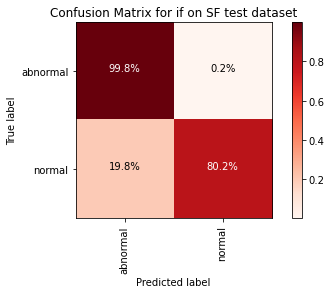

In [51]:
t, s = model("if", "SF")

In [71]:
# sf = datasets.fetch_kddcup99(subset='SF', random_state=0, percent10=False)
# dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsa = pd.read_csv('kddcup.data.csv', delimiter=',')
dfsa.columns = sa_columns + ["target"]
dfsa = dfsa[sa_columns+["target"]]
anomaly_rate_sf = 1.0 - len(dfsa.loc[dfsa["target"]=='normal.'])/len(dfsa)
print(f"SA anomaly rate is {anomaly_rate_sf:.1%}")

toDecodeSA = ["protocol_type", "service", "flag", "target"]
dfsa['binary_target'] = [1 if x=='normal.' else -1 for x in dfsa["target"]]
# toDecodeSF = ["service", "target"]    
le = preprocessing.LabelEncoder()
for f in toDecodeSA:
     dfsa[f] = le.fit_transform(dfsa[f])

X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(dfsa.drop(["target", 'binary_target'], axis=1), dfsa['binary_target'], test_size=0.33, random_state=0)

SA anomaly rate is 80.1%


In [72]:
np.array(dfsa.head(1))

array([[0.000e+00, 1.000e+00, 2.400e+01, 9.000e+00, 1.620e+02, 4.528e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.100e+01,
        1.000e+00]])

In [79]:
num_extimators = 100
max_samples = 0.25
contamination = 0.8
eps = 0.2

ifsf = IsolationForest(max_samples=max_samples, random_state=0, contamination=contamination, n_estimators=num_extimators, n_jobs=-1)
lofsf = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=contamination, n_jobs=-1)
ocsvm = OneClassSVM(nu=contamination, kernel="rbf",gamma=0.1)
dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1)
estimators = {
    "if": ifsf,
    "lof": lofsf,
    "dbs": dbscan,
    "svm": ocsvm
}

trainning finished in 0:08:25.929799
              precision    recall  f1-score   support

     anomaly       0.67      0.51      0.58   1295823
      normal       0.00      0.00      0.00    320659

    accuracy                           0.41   1616482
   macro avg       0.34      0.25      0.29   1616482
weighted avg       0.54      0.41      0.46   1616482

AUC:  25.5%


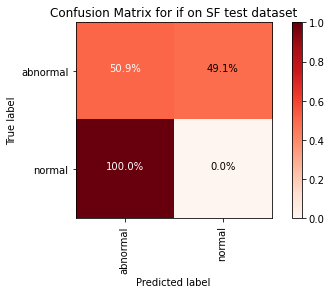

In [80]:
t, s = model("if", "SA")